## Preambule

In [2]:
# Preparation: Import Braket libraries
from braket.circuits import circuit, Circuit, Gate, Moments
from braket.circuits.instruction import Instruction
from braket.aws import AwsQuantumTask, AwsDevice
from braket.devices import LocalSimulator
import matplotlib.pyplot as plt
import csv

# Preparation: Magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np
from math import pi

In [3]:
def ang(ratio):
    return 2 * np.arctan(np.sqrt(ratio))

In [4]:
@circuit.subroutine(register=True)
def ch(control, target):
    circ = Circuit().rz(target,pi/2).cnot(control,target).rz(target,-pi/2).ry(target,-pi/4).cnot(control,target).ry(target,pi/4).s(control)
    
    return circ

In [5]:
@circuit.subroutine(register=True)
def cry(control, target, angle):
    circ = Circuit().ry(target,angle/2).cnot(control,target).ry(target,-angle/2).cnot(control,target)
    
    return circ

In [6]:
@circuit.subroutine(register=True)
def ccnot(controls, target):
    cqb1, cqb2 = controls
    circ = Circuit().h(target).cnot(cqb2,target).ti(target).cnot(cqb1,target).t(target).cnot(cqb2,target).ti(target).cnot(cqb1,target).t(target).h(target).t(cqb2).cnot(cqb1,cqb2).t(cqb1).ti(cqb2).cnot(cqb1,cqb2)
    
    return circ

In [7]:
@circuit.subroutine(register=True)
def mcry(ctrl, target, revctrl, theta): #theta = float(angle), ctrl = list[int], target = int
    circ = Circuit()
    
    for i in revctrl:
        circ.x(i)
    circ.ry(target, theta/2)
    circ.ccnot(ctrl,target)
    circ.ry(target, -theta/2)
    circ.ccnot(ctrl,target)
    for i in revctrl:
        circ.x(i)
    
    return circ

In [11]:
def demo_2q():
    state_list = []

    circ = Circuit().cnot(0,1)
    state_list.append(circ)
    
    circ = Circuit().x(0).x(1)
    state_list.append(circ)
    
    circ = Circuit().ch(0,1)
    state_list.append(circ)
    
    return state_list

## Entanglement Certifying Circuit

In [12]:
def ecc(gate):
    ## STATE PREPARATION
    gate = gate
    
    ## ENTANGLEMENT WITNESS
    wit = Circuit()
    wit.x(1)
    wit.h(0)
    
    wit.cnot(0,1)
    wit.ch(1,0)
    wit.cnot(0,1)
    
    wit.cnot(0,2)
    wit.cnot(1,3)
    
    wit.h(0)
    wit.cnot(0,1)
    
    circ = wit + gate + Circuit().h(0)
    return circ

# Demo
state_list = demo_2q()
print(ecc(state_list[0]))

T  : |0|1|   2    |3|    4    |    5    |6|   7    |8| 9 |10|11|12|13|
                                                                      
q0 : -H-C-Rz(1.57)-X-Rz(-1.57)-Ry(-0.79)-X-Ry(0.79)-C-C---H--C--C--H--
        |          |                     |          | |      |  |     
q1 : -X-X----------C---------------------C-S--------X-|-C----X--X-----
                                                      | |             
q2 : -------------------------------------------------X-|-------------
                                                        |             
q3 : ---------------------------------------------------X-------------

T  : |0|1|   2    |3|    4    |    5    |6|   7    |8| 9 |10|11|12|13|


{'0110': 130, '0010': 125, '1111': 269, '1110': 117, '1011': 268, '0011': 278, '1101': 125, '1001': 131, '1010': 112, '0111': 243, '0101': 128, '0001': 122, 'value': 0.25634765625}
Expectation Value Outcomes
0.25634765625
{'00': 525, '01': 501, '10': 511, '11': 511}
Noise rate: 6.40869140625
The given gate is not capable of generating entanglement.


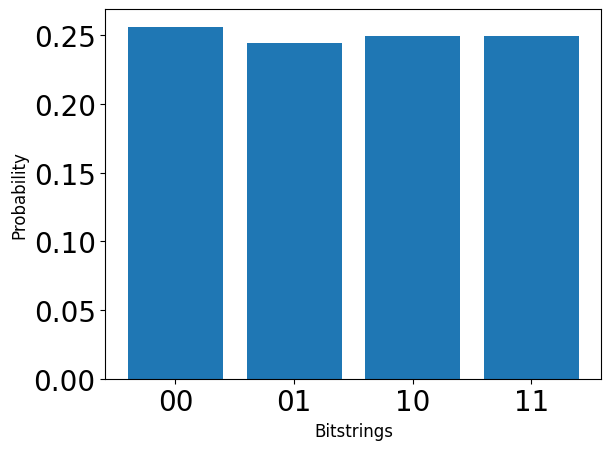

In [18]:
def certify_cnot(gate, shots, device, bucket_name, prefix, filename):
    # Initial sequences
    import numpy
    shots = shots
    device = AwsDevice(device)
    my_bucket = bucket_name # the name of the bucket: "amazon-braket-qitkaistuser3"
    my_prefix = prefix # the name of the folder in the bucket: "observable-output"
    s3_folder = (my_bucket, my_prefix)
    
    # Set bitstrings for data collection
    format_bitstring = '{0:0' + str(4) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**4)]
    header = ['value'] + [format_bitstring.format(ii) for ii in range(2**4)]

    # Prepare the entanglement certifying circuit with the certified gate
    circ = ecc(gate)
    
    # Execute CNOT certification and Collect the measurement outcome
    task = device.run(circ, s3_folder, shots)
    counts = task.result().measurement_counts
    value = 0
    for bitstring in counts.keys():
        if bitstring[0:2] == '00':
            value += counts[bitstring]
    value = value/shots
    entry = dict(counts)
    entry.update({'value': value})
    print(entry)

    print("Expectation Value Outcomes")
    print(value)
    
    # Data post-processing: tracing out the ancillae
    reduced_bitstring = '{0:0' + str(2) + 'b}'
    reduced_bitstring_keys = [reduced_bitstring.format(ii) for ii in range(2**2)]
    redata = dict()
    for bitstring in reduced_bitstring_keys:
        redata.update({bitstring: 0})
    for bitstring in counts.keys():
        redata[bitstring[0:2]] += counts[bitstring]
    print(redata)

    check = 0
    for key in redata.keys():
        check += redata[key]
        redata[key] /= 2048
        
    if check != 2048:
        print("Fatal error occured!")
    noise = redata['00'] * 100 / 4
    print("Noise rate: " + str(noise))
    if (redata['00'] < 0.125) or (redata['00'] > 0.375):
        print("The given gate is capable of generating entanglement.")
    else:
        print("The given gate is not capable of generating entanglement.")

    # Plot the measurement outcome with the ancillae traced out
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('axes', labelsize=12) 
    plt.bar(redata.keys(), redata.values())
    plt.xlabel('Bitstrings')
    plt.ylabel('Probability')
    
    # Name of csv file 
    filename = filename # "patent_demo_aria_cn_sv1.csv"
    # Writing to csv file 
    with open(filename, 'w') as csvfile: 
        # creating a csv dict writer object 
        writer = csv.DictWriter(csvfile, fieldnames = header)      
        # writing headers (field names) 
        writer.writeheader()
        writer.writerows([entry])
        
certify_cnot(Circuit().x(0).x(1), 2048, "arn:aws:braket:::device/quantum-simulator/amazon/sv1", "amazon-braket-qitkaistuser3", "observable-output", "patent_demo_sv1_cn.csv")